In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.image import imread
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import math


In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    print("error")

In [12]:
#dataset
transformer = transforms.Compose([transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transformer
)
test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transformer

)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                         batch_size=16,
                                         shuffle=False,
                                         num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, _make_divisible(channel // reduction, 8)),
                nn.ReLU(inplace=True),
                nn.Linear(_make_divisible(channel // reduction, 8), channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size, stride, use_se, use_hs):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        self.identity = stride == 1 and inp == oup

        if inp == hidden_dim:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV3(nn.Module):
    def __init__(self, cfgs, mode, num_classes=10, width_mult=1.):
        super(MobileNetV3, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = cfgs
        assert mode in ['large', 'small']

        # building first layer
        input_channel = _make_divisible(16 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = InvertedResidual
        for k, t, c, use_se, use_hs, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            exp_size = _make_divisible(input_channel * t, 8)
            layers.append(block(input_channel, exp_size, output_channel, k, s, use_se, use_hs))
            input_channel = output_channel
        self.features = nn.Sequential(*layers)
        # building last several layers
        self.conv = conv_1x1_bn(input_channel, exp_size)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        output_channel = {'large': 1280, 'small': 1024}
        output_channel = _make_divisible(output_channel[mode] * width_mult, 8) if width_mult > 1.0 else output_channel[mode]
        self.classifier = nn.Sequential(
            nn.Linear(exp_size, output_channel),
            h_swish(),
            nn.Dropout(0.2),
            nn.Linear(output_channel, num_classes),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def mobilenetv3_large(**kwargs):
    """
    Constructs a MobileNetV3-Large model
    """
    cfgs = [
        # k, t, c, SE, HS, s 
        [3,   1,  16, 0, 0, 1],
        [3,   4,  24, 0, 0, 2],
        [3,   3,  24, 0, 0, 1],
        [5,   3,  40, 1, 0, 2],
        [5,   3,  40, 1, 0, 1],
        [5,   3,  40, 1, 0, 1],
        [3,   6,  80, 0, 1, 2],
        [3, 2.5,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [5,   6, 160, 1, 1, 2],
        [5,   6, 160, 1, 1, 1],
        [5,   6, 160, 1, 1, 1]
    ]
    return MobileNetV3(cfgs, mode='large', **kwargs)


def mobilenetv3_small(**kwargs):
    """
    Constructs a MobileNetV3-Small model
    """
    cfgs = [
        # k, t, c, SE, HS, s 
        [3,    1,  16, 1, 0, 2],
        [3,  4.5,  24, 0, 0, 2],
        [3, 3.67,  24, 0, 0, 1],
        [5,    4,  40, 1, 1, 2],
        [5,    6,  40, 1, 1, 1],
        [5,    6,  40, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    6,  96, 1, 1, 2],
        [5,    6,  96, 1, 1, 1],
        [5,    6,  96, 1, 1, 1],
    ]

    return MobileNetV3(cfgs, mode='small', **kwargs)

In [14]:
train_losses = []
train_accuracy = [] 
test_losses = []
test_accuracy = []

def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, prediction = outputs.max(1)

        total += labels.size(0)
        correct += prediction.eq(labels).sum().item()

        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current train accuracy:', str(prediction.eq(labels).sum().item() / labels.size(0)))
            print('Current train average loss:', loss.item() / labels.size(0))

            train_losses.append(loss.item() / labels.size(0))
            train_accuracy.append(prediction.eq(labels).sum().item() / labels.size(0))
            
    print('\nTrain accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)

In [15]:
def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        total += labels.size(0)

        outputs = net(images)
        loss += criterion(outputs, labels).item()

        _, prediction = outputs.max(1)
        correct += prediction.eq(labels).sum().item()

    print('\nTest accuarcy:', correct / total)
    print('Test average loss:', loss / total)
    test_losses.append(loss / total)
    test_accuracy.append(correct / total)

    state = {
        'net': net.state_dict()
    }

    file_name = 'CNN_depthwise.pt'
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved')

In [16]:
net = mobilenetv3_small()
net = net.to(device)

learning_rate = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)

In [17]:
# count_parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
print(count_parameters(net)/1000000,str('M'))

1.528106 M


In [19]:
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    #if epoch >= 50:
    if epoch >= 50:
        lr /= 10
    #if epoch >= 100:
    if epoch >= 100:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


In [20]:
start_time = time.time()

for epoch in range(0, 60):
    #adjust_learning_rate(optimizer, epoch)
    train(epoch)
    test(epoch)
    print('\nTime elapsed:', time.time() - start_time)


[ Train epoch: 0 ]

Current batch: 0
Current train accuracy: 0.0
Current train average loss: 0.07208652794361115

Current batch: 100
Current train accuracy: 0.28125
Current train average loss: 0.0602208748459816

Current batch: 200
Current train accuracy: 0.25
Current train average loss: 0.06217340752482414

Current batch: 300
Current train accuracy: 0.15625
Current train average loss: 0.06836426258087158

Current batch: 400
Current train accuracy: 0.3125
Current train average loss: 0.06282458454370499

Current batch: 500
Current train accuracy: 0.1875
Current train average loss: 0.07178477197885513

Current batch: 600
Current train accuracy: 0.1875
Current train average loss: 0.0640471875667572

Current batch: 700
Current train accuracy: 0.28125
Current train average loss: 0.0623350515961647

Current batch: 800
Current train accuracy: 0.21875
Current train average loss: 0.06503565609455109

Current batch: 900
Current train accuracy: 0.1875
Current train average loss: 0.06396731734275


Current batch: 1000
Current train accuracy: 0.25
Current train average loss: 0.06712637841701508

Current batch: 1100
Current train accuracy: 0.1875
Current train average loss: 0.0721074715256691

Current batch: 1200
Current train accuracy: 0.09375
Current train average loss: 0.07237937301397324

Current batch: 1300
Current train accuracy: 0.125
Current train average loss: 0.06812755018472672

Current batch: 1400
Current train accuracy: 0.125
Current train average loss: 0.07187482714653015

Current batch: 1500
Current train accuracy: 0.25
Current train average loss: 0.06527450680732727

Train accuarcy: 16.29
Train average loss: 0.06960506879091263

[ Test epoch: 4 ]

Test accuarcy: 0.1736
Test average loss: 0.13568388534784318
Model Saved

Time elapsed: 338.4782466888428

[ Train epoch: 5 ]

Current batch: 0
Current train accuracy: 0.1875
Current train average loss: 0.06836743652820587

Current batch: 100
Current train accuracy: 0.09375
Current train average loss: 0.07363151013851166



Current batch: 200
Current train accuracy: 0.09375
Current train average loss: 0.06763884425163269

Current batch: 300
Current train accuracy: 0.21875
Current train average loss: 0.0685599073767662

Current batch: 400
Current train accuracy: 0.25
Current train average loss: 0.06338267028331757

Current batch: 500
Current train accuracy: 0.125
Current train average loss: 0.06834617257118225

Current batch: 600
Current train accuracy: 0.125
Current train average loss: 0.0645146444439888

Current batch: 700
Current train accuracy: 0.40625
Current train average loss: 0.058909714221954346

Current batch: 800
Current train accuracy: 0.3125
Current train average loss: 0.05402795597910881

Current batch: 900
Current train accuracy: 0.1875
Current train average loss: 0.06165853515267372

Current batch: 1000
Current train accuracy: 0.25
Current train average loss: 0.07000387459993362

Current batch: 1100
Current train accuracy: 0.25
Current train average loss: 0.06244850531220436

Current batch


Current batch: 1300
Current train accuracy: 0.1875
Current train average loss: 0.06535361707210541

Current batch: 1400
Current train accuracy: 0.21875
Current train average loss: 0.0673631951212883

Current batch: 1500
Current train accuracy: 0.28125
Current train average loss: 0.06884825974702835

Train accuarcy: 19.272
Train average loss: 0.06631908879041672

[ Test epoch: 13 ]

Test accuarcy: 0.2328
Test average loss: 0.1290444118499756
Model Saved

Time elapsed: 947.2466571331024

[ Train epoch: 14 ]

Current batch: 0
Current train accuracy: 0.25
Current train average loss: 0.06229640170931816

Current batch: 100
Current train accuracy: 0.1875
Current train average loss: 0.06950367242097855

Current batch: 200
Current train accuracy: 0.34375
Current train average loss: 0.05752946063876152

Current batch: 300
Current train accuracy: 0.15625
Current train average loss: 0.062258172780275345

Current batch: 400
Current train accuracy: 0.21875
Current train average loss: 0.06700603663


Current batch: 500
Current train accuracy: 0.40625
Current train average loss: 0.04696297273039818

Current batch: 600
Current train accuracy: 0.34375
Current train average loss: 0.049670495092868805

Current batch: 700
Current train accuracy: 0.375
Current train average loss: 0.055101677775382996

Current batch: 800
Current train accuracy: 0.34375
Current train average loss: 0.06126423552632332

Current batch: 900
Current train accuracy: 0.40625
Current train average loss: 0.054593782871961594

Current batch: 1000
Current train accuracy: 0.28125
Current train average loss: 0.06359589844942093

Current batch: 1100
Current train accuracy: 0.46875
Current train average loss: 0.050635676831007004

Current batch: 1200
Current train accuracy: 0.5
Current train average loss: 0.04820464923977852

Current batch: 1300
Current train accuracy: 0.46875
Current train average loss: 0.04678267985582352

Current batch: 1400
Current train accuracy: 0.28125
Current train average loss: 0.056998562067747


Current batch: 1500
Current train accuracy: 0.46875
Current train average loss: 0.049024924635887146

Train accuarcy: 42.824
Train average loss: 0.04910611444473267

[ Test epoch: 22 ]

Test accuarcy: 0.4359
Test average loss: 0.096586608594656
Model Saved

Time elapsed: 1555.28648519516

[ Train epoch: 23 ]

Current batch: 0
Current train accuracy: 0.40625
Current train average loss: 0.04674829542636871

Current batch: 100
Current train accuracy: 0.40625
Current train average loss: 0.04710754379630089

Current batch: 200
Current train accuracy: 0.46875
Current train average loss: 0.04118436947464943

Current batch: 300
Current train accuracy: 0.28125
Current train average loss: 0.051774490624666214

Current batch: 400
Current train accuracy: 0.4375
Current train average loss: 0.04878741502761841

Current batch: 500
Current train accuracy: 0.21875
Current train average loss: 0.05797532945871353

Current batch: 600
Current train accuracy: 0.40625
Current train average loss: 0.047626614


Current batch: 700
Current train accuracy: 0.375
Current train average loss: 0.05066147446632385

Current batch: 800
Current train accuracy: 0.28125
Current train average loss: 0.05595816671848297

Current batch: 900
Current train accuracy: 0.4375
Current train average loss: 0.05237351730465889

Current batch: 1000
Current train accuracy: 0.5625
Current train average loss: 0.04289431497454643

Current batch: 1100
Current train accuracy: 0.40625
Current train average loss: 0.051658932119607925

Current batch: 1200
Current train accuracy: 0.28125
Current train average loss: 0.05540979653596878

Current batch: 1300
Current train accuracy: 0.5
Current train average loss: 0.042011383920907974

Current batch: 1400
Current train accuracy: 0.53125
Current train average loss: 0.04216398298740387

Current batch: 1500
Current train accuracy: 0.40625
Current train average loss: 0.0549759604036808

Train accuarcy: 45.06
Train average loss: 0.04726387208104134

[ Test epoch: 27 ]

Test accuarcy: 0.


Test accuarcy: 0.4649
Test average loss: 0.0908116106569767
Model Saved

Time elapsed: 2165.681088209152

[ Train epoch: 32 ]

Current batch: 0
Current train accuracy: 0.5625
Current train average loss: 0.04182439669966698

Current batch: 100
Current train accuracy: 0.4375
Current train average loss: 0.049479641020298004

Current batch: 200
Current train accuracy: 0.5
Current train average loss: 0.040766336023807526

Current batch: 300
Current train accuracy: 0.5
Current train average loss: 0.05086735263466835

Current batch: 400
Current train accuracy: 0.375
Current train average loss: 0.056966908276081085

Current batch: 500
Current train accuracy: 0.40625
Current train average loss: 0.051192522048950195

Current batch: 600
Current train accuracy: 0.5
Current train average loss: 0.043856676667928696

Current batch: 700
Current train accuracy: 0.4375
Current train average loss: 0.04648594185709953

Current batch: 800
Current train accuracy: 0.59375
Current train average loss: 0.03932


Current batch: 900
Current train accuracy: 0.5
Current train average loss: 0.04347929358482361

Current batch: 1000
Current train accuracy: 0.53125
Current train average loss: 0.04370561242103577

Current batch: 1100
Current train accuracy: 0.5
Current train average loss: 0.043597690761089325

Current batch: 1200
Current train accuracy: 0.34375
Current train average loss: 0.050030965358018875

Current batch: 1300
Current train accuracy: 0.46875
Current train average loss: 0.04616528004407883

Current batch: 1400
Current train accuracy: 0.53125
Current train average loss: 0.039961230009794235

Current batch: 1500
Current train accuracy: 0.53125
Current train average loss: 0.04246905818581581

Train accuarcy: 47.084
Train average loss: 0.045817184755802154

[ Test epoch: 36 ]

Test accuarcy: 0.4691
Test average loss: 0.09291451727151871
Model Saved

Time elapsed: 2502.95032954216

[ Train epoch: 37 ]

Current batch: 0
Current train accuracy: 0.46875
Current train average loss: 0.0501079


Current batch: 100
Current train accuracy: 0.5
Current train average loss: 0.04190026968717575

Current batch: 200
Current train accuracy: 0.71875
Current train average loss: 0.03493072837591171

Current batch: 300
Current train accuracy: 0.625
Current train average loss: 0.03274054825305939

Current batch: 400
Current train accuracy: 0.5
Current train average loss: 0.046130307018756866

Current batch: 500
Current train accuracy: 0.40625
Current train average loss: 0.05173334851861

Current batch: 600
Current train accuracy: 0.53125
Current train average loss: 0.04660367965698242

Current batch: 700
Current train accuracy: 0.40625
Current train average loss: 0.04806313291192055

Current batch: 800
Current train accuracy: 0.71875
Current train average loss: 0.031096259132027626

Current batch: 900
Current train accuracy: 0.5
Current train average loss: 0.04332224279642105

Current batch: 1000
Current train accuracy: 0.53125
Current train average loss: 0.04062390327453613

Current batch


Current batch: 1200
Current train accuracy: 0.375
Current train average loss: 0.05446360260248184

Current batch: 1300
Current train accuracy: 0.4375
Current train average loss: 0.052681952714920044

Current batch: 1400
Current train accuracy: 0.65625
Current train average loss: 0.04015224054455757

Current batch: 1500
Current train accuracy: 0.5625
Current train average loss: 0.03557133302092552

Train accuarcy: 48.28
Train average loss: 0.044772526836395266

[ Test epoch: 45 ]

Test accuarcy: 0.4917
Test average loss: 0.08884748394489288
Model Saved

Time elapsed: 3109.939755678177

[ Train epoch: 46 ]

Current batch: 0
Current train accuracy: 0.40625
Current train average loss: 0.05101427808403969

Current batch: 100
Current train accuracy: 0.5625
Current train average loss: 0.038659628480672836

Current batch: 200
Current train accuracy: 0.25
Current train average loss: 0.052717652171850204

Current batch: 300
Current train accuracy: 0.46875
Current train average loss: 0.044850688


Current batch: 400
Current train accuracy: 0.5
Current train average loss: 0.04164524003863335

Current batch: 500
Current train accuracy: 0.53125
Current train average loss: 0.04601123929023743

Current batch: 600
Current train accuracy: 0.5625
Current train average loss: 0.039612896740436554

Current batch: 700
Current train accuracy: 0.59375
Current train average loss: 0.04284582659602165

Current batch: 800
Current train accuracy: 0.40625
Current train average loss: 0.0490248017013073

Current batch: 900
Current train accuracy: 0.46875
Current train average loss: 0.04913119971752167

Current batch: 1000
Current train accuracy: 0.5
Current train average loss: 0.041418664157390594

Current batch: 1100
Current train accuracy: 0.625
Current train average loss: 0.042002804577350616

Current batch: 1200
Current train accuracy: 0.5625
Current train average loss: 0.036046240478754044

Current batch: 1300
Current train accuracy: 0.53125
Current train average loss: 0.047485362738370895

Cur


Current batch: 1400
Current train accuracy: 0.59375
Current train average loss: 0.05455286428332329

Current batch: 1500
Current train accuracy: 0.34375
Current train average loss: 0.056298960000276566

Train accuarcy: 49.084
Train average loss: 0.044324912201166154

[ Test epoch: 54 ]

Test accuarcy: 0.5054
Test average loss: 0.08597188556194306
Model Saved

Time elapsed: 3711.7404062747955

[ Train epoch: 55 ]

Current batch: 0
Current train accuracy: 0.53125
Current train average loss: 0.038505226373672485

Current batch: 100
Current train accuracy: 0.53125
Current train average loss: 0.04516730457544327

Current batch: 200
Current train accuracy: 0.53125
Current train average loss: 0.04010695964097977

Current batch: 300
Current train accuracy: 0.5625
Current train average loss: 0.04099242761731148

Current batch: 400
Current train accuracy: 0.40625
Current train average loss: 0.06226646527647972

Current batch: 500
Current train accuracy: 0.40625
Current train average loss: 0.048


Current batch: 600
Current train accuracy: 0.5625
Current train average loss: 0.04036008194088936

Current batch: 700
Current train accuracy: 0.5625
Current train average loss: 0.04123712703585625

Current batch: 800
Current train accuracy: 0.5
Current train average loss: 0.049810875207185745

Current batch: 900
Current train accuracy: 0.53125
Current train average loss: 0.047518663108348846

Current batch: 1000
Current train accuracy: 0.34375
Current train average loss: 0.05283522233366966

Current batch: 1100
Current train accuracy: 0.375
Current train average loss: 0.05449096858501434

Current batch: 1200
Current train accuracy: 0.5
Current train average loss: 0.04512111842632294

Current batch: 1300
Current train accuracy: 0.375
Current train average loss: 0.05212279409170151

Current batch: 1400
Current train accuracy: 0.59375
Current train average loss: 0.039927322417497635

Current batch: 1500
Current train accuracy: 0.40625
Current train average loss: 0.055685240775346756

Tra

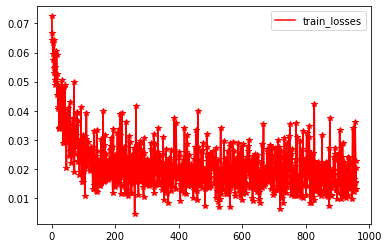

In [12]:
df_train_l = pd.DataFrame(train_losses, columns = ['train_losses'])
df_train_l.plot(color = "#ff0000")
plt.plot(df_train_l, marker = '*', color = 'r')
plt.show()



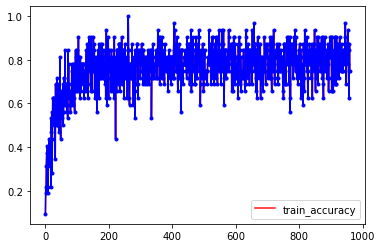

In [13]:
df_train_a = pd.DataFrame(train_accuracy, columns = ['train_accuracy'])
df_train_a.plot(color = "#ff1111")
plt.plot(df_train_a, marker = '.', color = 'b')
plt.show()


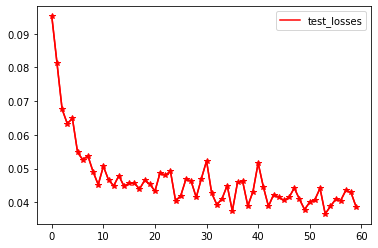

In [14]:
df_test_l = pd.DataFrame(test_losses, columns = ['test_losses'])
df_test_l.plot(color = "#ff0000")
plt.plot(df_test_l, marker = '*', color = 'r')
plt.show()


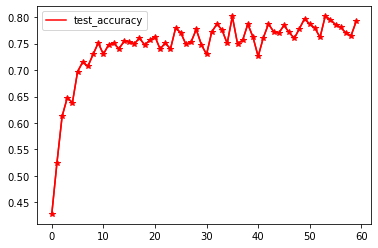

In [15]:
df_test_a = pd.DataFrame(test_accuracy, columns = ['test_accuracy'])
df_test_a.plot(color = "#ff0000")
plt.plot(df_test_a, marker = '*', color = 'r')
plt.show()


In [22]:
pip install update

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install ptflops

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install --upgrade git+https://github.com/sovrasov/flops-counter.pytorch.git

  Running command git clone -q https://github.com/sovrasov/flops-counter.pytorch.git 'C:\Users\admin\AppData\Local\Temp\pip-req-build-8x3qg9jw'


  Cloning https://github.com/sovrasov/flops-counter.pytorch.git to c:\users\admin\appdata\local\temp\pip-req-build-8x3qg9jw



  ERROR: Error [WinError 2] 지정된 파일을 찾을 수 없습니다 while executing command git clone -q https://github.com/sovrasov/flops-counter.pytorch.git 'C:\Users\admin\AppData\Local\Temp\pip-req-build-8x3qg9jw'
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


In [21]:
# Multiply-Accumulate
pip install ptflops
pip install --upgrade git+https://github.com/sovrasov/flops-counter.pytorch.git
import torchvision.models as models
import torch
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
    macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))
    print('= ')

SyntaxError: invalid syntax (<ipython-input-21-711b33cc299d>, line 2)

In [25]:
# count_parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_paramete